# Прогнозирование метрик

## Задача 2

Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте их тоже указать.

***

Одна из основных метрик для нашего приложения социальной сети  - это общая активность (просмотры, лайки, а также сколько пользователей активны в конкретный день). Таким образом общее количество событий будет основной метрикой, которую мы прогнозируем, а в качестве ковариата (дополнительного регрессора) DAU. Для обучения модели мы берем временное разрешение с 3 сентября по 3 ноября, которое в полной мере охватит активность в нашем приложении, а также захватит промежуток, когда была проведена маркетинговая кампания и флэшмоб.

In [1]:
import orbit
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import mae, mse, smape, wmape

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #для визуализации MCMC

import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

2023-11-10 10:48:17.973796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 10:48:20.371554: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231020',
'user':'student',
'password':'dpo_python_2020'
}

In [3]:
query = """
SELECT toStartOfDay(time) day,
    action,
    user_id,
    post_id
FROM simulator_20231020.feed_actions
WHERE toDate(day) between '2023-09-03' and '2023-11-03'
ORDER BY time
"""

In [4]:
df = ph.read_clickhouse(query, connection=connection)

In [5]:
df.head()

,day,action,user_id,post_id
0,2023-09-03,view,1049,75
1,2023-09-03,view,107986,132
2,2023-09-03,view,455,172
3,2023-09-03,view,742,97
4,2023-09-03,view,2384,167


Выведем период, который будет задействован для обучения модели:

In [6]:
print(f"Начало: {df.day.min().date()} \nКонец: {(df.day.min() + pd.Timedelta(60, unit = 'd')).date()}")

Начало: 2023-09-03 
Конец: 2023-11-02


Теперь сделаем из этого нужные нам характеристики - общее количество событий и DAU в качестве ковариата:

In [7]:
act_df = df.groupby("day").agg({"user_id": "nunique", "action": "count"}).rename({"user_id": "DAU", "action": "activity"}, axis=1).reset_index()

In [9]:
act_df.shape

(62, 3)

In [8]:
act_df.head()

,day,DAU,activity
0,2023-09-03,3105,126484
1,2023-09-04,3721,142796
2,2023-09-05,4617,208958
3,2023-09-06,4728,202023
4,2023-09-07,4890,222575


Добавим заодно активность в плане сообщений:

In [11]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20231020',
'user':'student',
'password':'dpo_python_2020'
}

query = """
SELECT toStartOfDay(time) day,
    COUNT(receiver_id) actions_mes
FROM simulator_20231020.message_actions
WHERE day >= toDateTime('2023-09-03') and day < toDateTime('2023-11-03')
GROUP BY day
ORDER BY day
"""

mes_activity = ph.read_clickhouse(query=query, connection=connection)
mes_activity.head()

,day,actions_mes
0,2023-09-03,12897
1,2023-09-04,12897
2,2023-09-05,12898
3,2023-09-06,12899
4,2023-09-07,12898


In [12]:
act_df = act_df.merge(mes_activity)
act_df.head()

,day,DAU,activity,actions_mes
0,2023-09-03,3105,126484,12897
1,2023-09-04,3721,142796,12897
2,2023-09-05,4617,208958,12898
3,2023-09-06,4728,202023,12899
4,2023-09-07,4890,222575,12898


In [13]:
act_df["total_activity"] = act_df["activity"] + act_df["actions_mes"]
act_df.head()

,day,DAU,activity,actions_mes,total_activity
0,2023-09-03,3105,126484,12897,139381.0
1,2023-09-04,3721,142796,12897,155693.0
2,2023-09-05,4617,208958,12898,221856.0
3,2023-09-06,4728,202023,12899,214922.0
4,2023-09-07,4890,222575,12898,235473.0


Отметим ещё бинарным образом промежуток, когда проходил флешмоб (2023-10-12 по 2023-10-18), но пару днями позже, чтобы данные восстановились до нормального уровня после мероприятия, когда проходило само мероприятие. Поскольку эти дни являются некой аномалией ставим для них 1, а дляостальных дней 0:

In [15]:
act_df["anomaly"] = np.where((act_df.day >= "2023-10-12") & (act_df.day <= "2023-10-19"), 1, 0)
act_df.head()

,day,DAU,activity,actions_mes,total_activity,anomaly
0,2023-09-03,3105,126484,12897,139381.0,0
1,2023-09-04,3721,142796,12897,155693.0,0
2,2023-09-05,4617,208958,12898,221856.0,0
3,2023-09-06,4728,202023,12899,214922.0,0
4,2023-09-07,4890,222575,12898,235473.0,0


Для первичной работы стандартизуем наши модели:

In [19]:
act_mean = act_df.total_activity.mean()
act_sd = act_df.total_activity.std()

dau_mean = act_df.DAU.mean()
dau_sd = act_df.DAU.std()

act_df["DAU_stand"] = (act_df.DAU - dau_mean) / dau_sd
act_df["act_stand"] = (act_df.total_activity - act_mean) / act_sd

In [20]:
act_df.head()

,day,DAU,activity,actions_mes,total_activity,anomaly,DAU_stand,act_stand
0,2023-09-03,3105,126484,12897,139381.0,0,-2.252728,-1.599746
1,2023-09-04,3721,142796,12897,155693.0,0,-2.117363,-1.547762
2,2023-09-05,4617,208958,12898,221856.0,0,-1.920467,-1.336913
3,2023-09-06,4728,202023,12899,214922.0,0,-1.896075,-1.359010
4,2023-09-07,4890,222575,12898,235473.0,0,-1.860476,-1.293518


## Строим модели

Какие модели у нас будут:
1. Обычная модель с линейным трендом
2. Обычная модель с логлинейным трендом
3. Линейный тренд + DAU как регрессор
4. Логлинейный тренд + DAU как регрессор
5. Линейный тренд + DAU + аномалия
6. Логлинейный тренд + DAU + аномалия

In [21]:
simple_lin = DLT(response_col="act_stand", #название колонки с метрикой
          date_col = "day", #название колонки с датами-временем
          estimator="stan-mcmc", #алгоритм оценки
          global_trend_option = "linear",
          num_warmup=10000, #время "разогрева"
          num_sample=10000) #время сэмплирования 

simple_loglin = DLT(response_col="act_stand", 
               date_col = "day", 
               estimator='stan-mcmc',
               global_trend_option = 'loglinear',
               num_warmup=10000, 
               num_sample=10000) 

dau_lin = DLT(response_col="act_stand", 
               date_col = "day", 
               estimator='stan-mcmc',
               global_trend_option = 'linear',
               regressor_col = ["DAU_stand"], regressor_sign = ["+"],
               num_warmup=10000, 
               num_sample=10000) 

dau_loglin = DLT(response_col="act_stand", 
               date_col = "day", 
               estimator='stan-mcmc',
               global_trend_option = 'loglinear',
               regressor_col = ["DAU_stand"], regressor_sign = ["+"],
               num_warmup=10000, 
               num_sample=10000) 
anom_lin = DLT(response_col="act_stand", 
               date_col = "day", 
               estimator='stan-mcmc',
               global_trend_option = 'linear',
               regressor_col = ["DAU_stand", "anomaly"], regressor_sign = ["+", "+"],
               num_warmup=10000, 
               num_sample=10000) 

anom_loglin = DLT(response_col="act_stand", 
               date_col = "day", 
               estimator='stan-mcmc',
               global_trend_option = 'loglinear',
               regressor_col = ["DAU_stand", "anomaly"], regressor_sign = ["+", "+"],
               num_warmup=10000, 
               num_sample=10000) 

In [23]:
#Положим наши модели в список

model_list = [simple_lin, simple_loglin, dau_lin, dau_loglin, anom_lin, anom_loglin]

In [24]:
#Обучаем

for model in model_list:
    model.fit(act_df)

2023-11-10 11:44:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
2023-11-10 11:44:59 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 11:46:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 11:46:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 11:47:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 11:47:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 11:47:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Чтобы оценить предсказания, нам надо сотворить future df для наших моделек. Начнём с первых двух:

In [25]:
future = model_list[0].make_future_df(periods=30)

In [26]:
pred_1 = model_list[0].predict(future)
pred_2 = model_list[1].predict(future)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

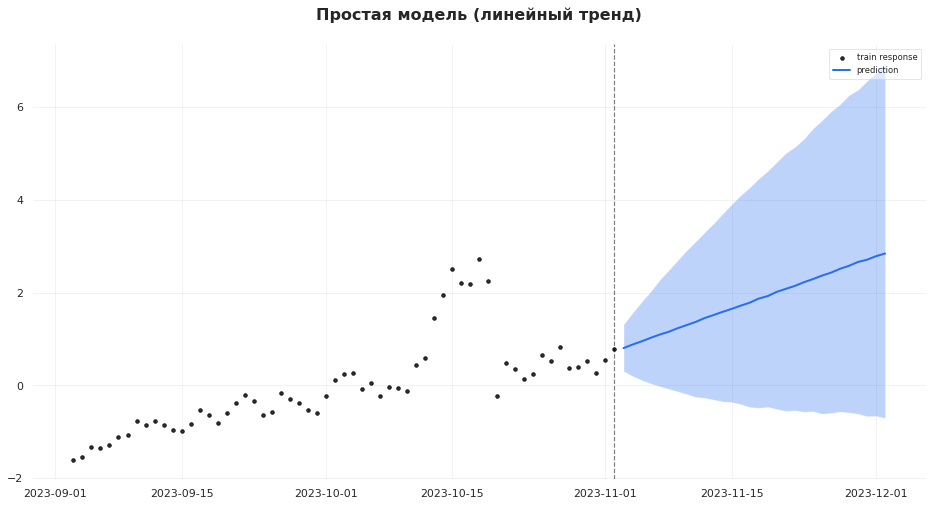

In [27]:
_ = plot_predicted_data(act_df, pred_1, "day", "act_stand", title = "Простая модель (линейный тренд)")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

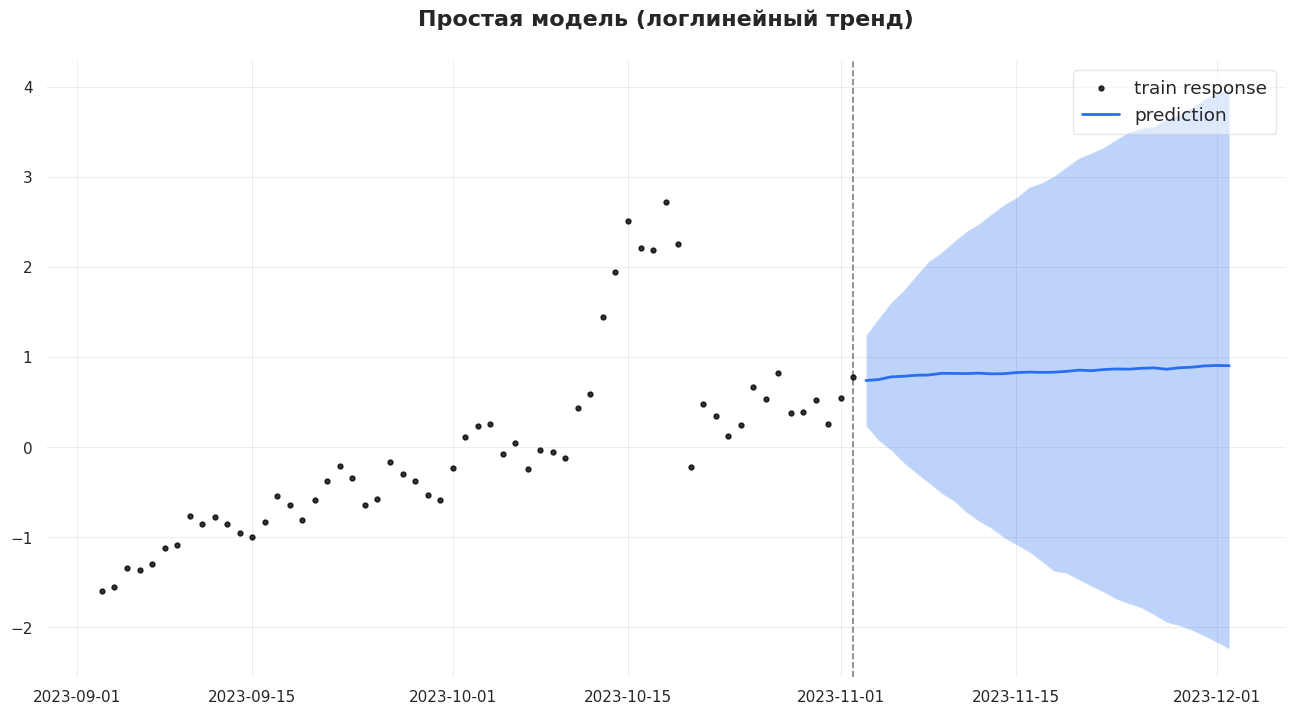

In [28]:
_ = plot_predicted_data(act_df, pred_2, "day", "act_stand", title = "Простая модель (логлинейный тренд)")

Для полагающихся на DAU моделей нам нужно дополнить наш df предсказаниями будущего DAU:

In [30]:
dau_model = DLT(response_col="DAU_stand", 
               date_col = "day", 
               estimator='stan-mcmc',
               global_trend_option = 'linear',
               num_warmup=10000, 
               num_sample=10000) 

dau_model.fit(act_df)
dau_pred = dau_model.predict(future)

2023-11-10 12:57:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

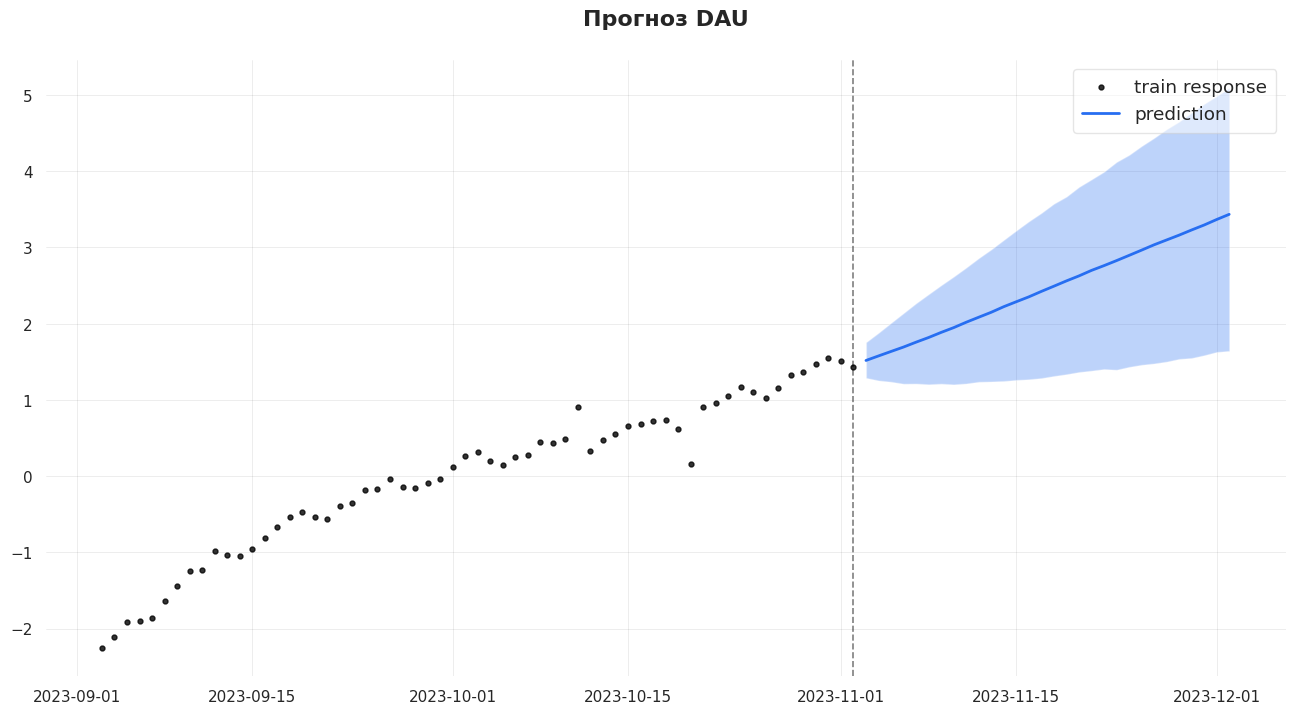

In [31]:
_ = plot_predicted_data(act_df, dau_pred, "day", "DAU_stand", title = "Прогноз DAU")

Добавим линейный прогноз в наш будущий df:

In [32]:
future["DAU_stand"] = dau_pred.prediction
future.head()

,day,DAU_stand
0,2023-11-03,1.516694
1,2023-11-04,1.576150
2,2023-11-05,1.634816
3,2023-11-06,1.692873
4,2023-11-07,1.756842


In [33]:
model_list[2].get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,DAU_stand,Positive,0.779232,0.291357,1.264903,1.0,0.0


In [34]:
pred_3 = model_list[2].predict(future)
pred_4 = model_list[3].predict(future)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

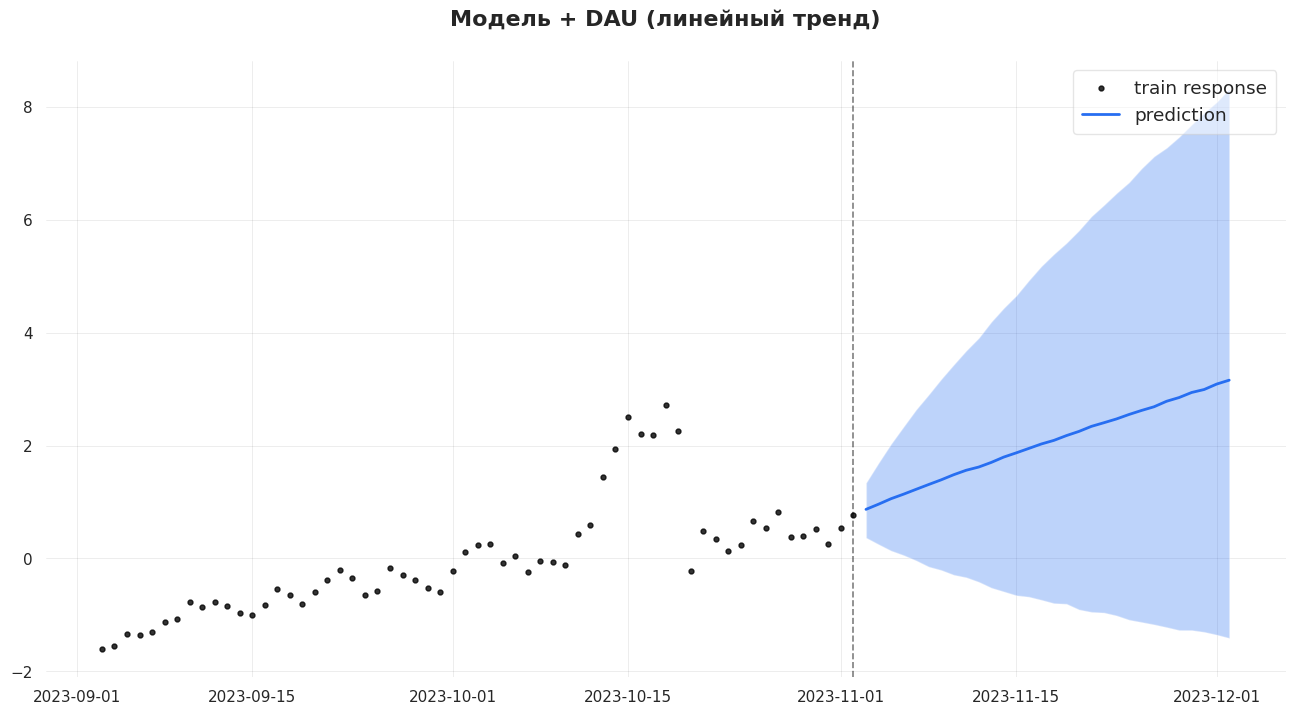

In [36]:
_ = plot_predicted_data(act_df, pred_3, "day", "act_stand", title = "Модель + DAU (линейный тренд)")

Попробуем добавить бинарную переменную:

In [37]:
future["anomaly"] = 0
future.head()

,day,DAU_stand,anomaly
0,2023-11-03,1.516694,0
1,2023-11-04,1.576150,0
2,2023-11-05,1.634816,0
3,2023-11-06,1.692873,0
4,2023-11-07,1.756842,0


In [2]:
pred_5 = model_list[4].predict(future)
pred_6 = model_list[5].predict(future)

NameError: name 'model_list' is not defined

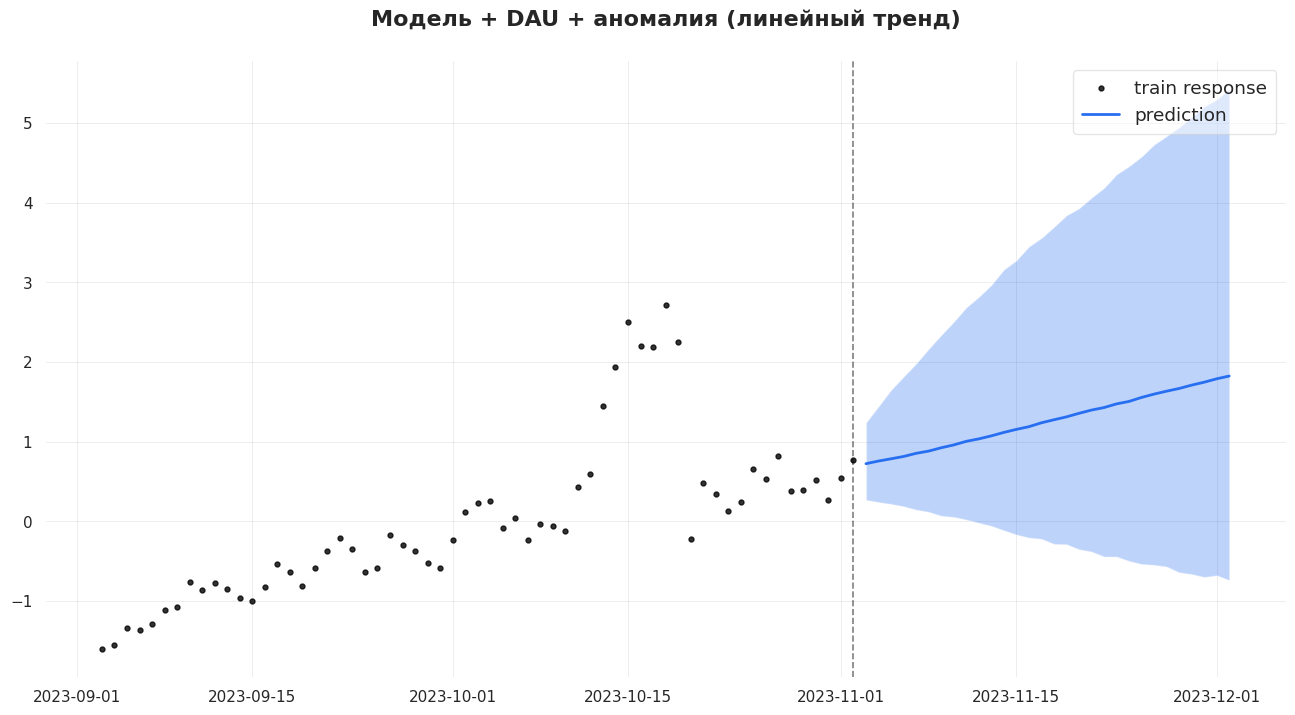

<Axes: title={'center': 'Модель + DAU + аномалия (линейный тренд)'}>

In [43]:
plot_predicted_data(act_df, pred_5, "day", "act_stand", title = "Модель + DAU + аномалия (линейный тренд)")

In [1]:
plot_predicted_data(act_df, pred_6, "day", "act_stand", title = "Модель + DAU + аномалия (логлинейный тренд)")

NameError: name 'plot_predicted_data' is not defined

Теперь необходимо оценить качество модели, сделаем это через бэктестинг

но чтобы его результаты были репрезентативными, нам необходимо сделать допущение, что характер поведения наших данных стабилен

## Оценим качество

In [46]:
test_list_rolling = []

for model in model_list:
    
    backtester = BackTester(
    model=model, #наша моделька
    df=act_df, #датафрейм для обучения
    min_train_len=7, #самый маленький кусочек данных, с которого начинается обучение
    incremental_len=7, #на сколько происходит прирост тренировочных данных
    forecast_len=7, #горизонт пронозирования
    window_type="rolling") #тип окошка
    
    backtester.fit_predict()
    
    test_list_rolling.append(backtester)

2023-11-10 13:41:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:41:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:42:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:43:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [47]:
test_list_exp= []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=act_df, 
    min_train_len=7, 
    incremental_len=7, 
    forecast_len=7, 
    window_type="expanding") 
    
    backtester.fit_predict()
    
    test_list_exp.append(backtester)

2023-11-10 13:44:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:44:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:45:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:46:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:46:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:46:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:46:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:46:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:46:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:47:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:47:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:47:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:47:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:47:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:47:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:48:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:48:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:48:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:48:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:48:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:48:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:49:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:49:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:49:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:49:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:49:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:50:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:50:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:50:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2023-11-10 13:50:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

Результаты:

In [52]:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)

roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

**Поскольку это метрики ошибки, соответственно, чем ниже метрика, тем модель лучше**

In [53]:
roll_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,1.081432,False
1,wmape,1.084685,False
1,mape,2.454882,False
1,mse,1.297127,False
1,mae,0.757604,False


In [51]:
for metric in roll_df.metric_name.unique():
    winning_model = roll_df.loc[roll_df.metric_name  == metric].metric_values.idxmin()
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 6
Самая лучшая модель по метрике wmape - 6
Самая лучшая модель по метрике mape - 6
Самая лучшая модель по метрике mse - 6
Самая лучшая модель по метрике mae - 6
Самая лучшая модель по метрике rmsse - 6


Все метрики показывают, что наилучшая модель именно **модель с логлинейнымым трендом, с DAU и с учетом аномалии**